In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [ ]:
# Load CIFAR-10 dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()

# Normalize pixel values to the range [0, 1]
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# One-hot encode labels
trainY = to_categorical(trainY, num_classes=10)
testY = to_categorical(testY, num_classes=10)

print(f"Train shape: {trainX.shape}, Test shape: {testX.shape}")

Train shape: (50000, 32, 32, 3), Test shape: (10000, 32, 32, 3)


In [ ]:
def build_mobilenet_cnn(input_shape, num_classes):
    # Load MobileNet as the backbone (pretrained on ImageNet)
    mobilenet = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze all layers of the backbone for transfer learning
    for layer in mobilenet.layers:
        layer.trainable = False

    # Add custom classification head
    inputs = mobilenet.input
    x = mobilenet.output
    x = Flatten(name='Flatten')(x)
    x = Dense(256, activation='relu', name='DenseLayer1')(x)
    outputs = Dense(num_classes, activation='softmax', name='OutputLayer')(x)

    # Build the model
    model = Model(inputs, outputs, name='MobileNet_CNN')
    model.summary()
    return model

In [ ]:
# Build and compile the model
mobilenet_cnn = build_mobilenet_cnn(input_shape=(32, 32, 3), num_classes=10)
mobilenet_cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_transfer = mobilenet_cnn.fit(trainX, trainY, validation_split=0.1, epochs=10, batch_size=32)

In [ ]:
test_loss_transfer, test_acc_transfer = mobilenet_cnn.evaluate(testX, testY)
print(f"Test Accuracy (Transfer Learning Only): {test_acc_transfer}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.2351 - loss: 2.1289
Test Accuracy (Transfer Learning Only): 0.23469999432563782


In [ ]:
# Unfreeze deeper layers of the backbone for fine-tuning
for layer in mobilenet_cnn.layers[-30:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
mobilenet_cnn.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_finetune = mobilenet_cnn.fit(trainX, trainY, validation_split=0.1, epochs=10, batch_size=32)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 478s 327ms/step - accuracy: 0.4084 - loss: 2.0076 - val_accuracy: 0.5938 - val_loss: 1.1561
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 496s 323ms/step - accuracy: 0.6010 - loss: 1.1522 - val_accuracy: 0.6794 - val_loss: 0.9258
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 502s 323ms/step - accuracy: 0.6767 - loss: 0.9439 - val_accuracy: 0.7280 - val_loss: 0.7929
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 497s 320ms/step - accuracy: 0.7208 - loss: 0.8145 - val_accuracy: 0.7474 - val_loss: 0.7315
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 447s 318ms/step - accuracy: 0.7514 - loss: 0.7173 - val_accuracy: 0.7694 - val_loss: 0.6721
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 445s 316ms/step - accuracy: 0.7759 - loss: 0.6473 - val_accuracy: 0.7782 - val_loss: 0.6595
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 447s 318ms/step - accuracy: 0.8037 - loss: 0.5641 - val_accuracy: 0.7924 - val_loss: 0.6125
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 446s 317ms/step - ac

In [ ]:
test_loss_finetune, test_acc_finetune = mobilenet_cnn.evaluate(testX, testY)
print(f"Test Accuracy (Transfer Learning + Fine-Tuning): {test_acc_finetune}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8060 - loss: 0.6048
Test Accuracy (Transfer Learning + Fine-Tuning): 0.8012999892234802


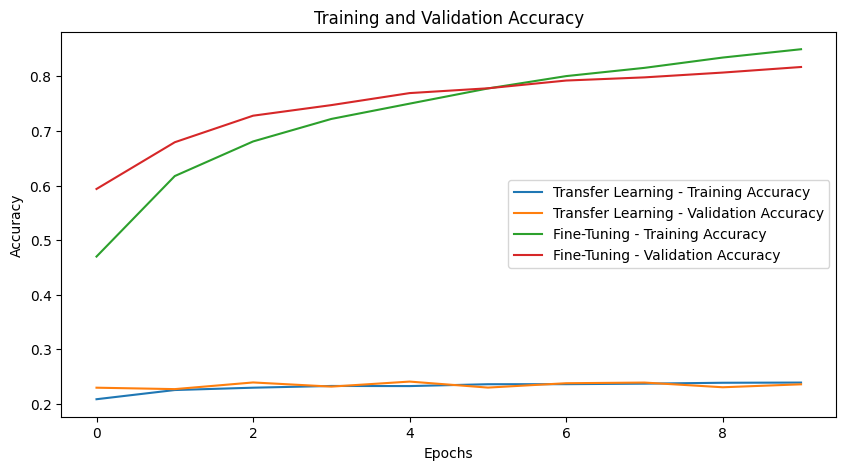

In [ ]:
# Plot training and validation accuracy for both phases
plt.figure(figsize=(10, 5))
plt.plot(history_transfer.history['accuracy'], label='Transfer Learning - Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Transfer Learning - Validation Accuracy')
plt.plot(history_finetune.history['accuracy'], label='Fine-Tuning - Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine-Tuning - Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()